# Arima Time Series Model

#### Library Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from pmdarima.arima import auto_arima
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings("ignore")

In [2]:
#pip show statsmodels

#### Bring dataframes from ForecastingStockVolatility.ipynb

In [3]:
boeing_df =  pd.read_pickle('data/boeing_prep4.pkl')

In [5]:
boeing_df.index=boeing_df['date']

### Closing Price of Boeing Stock

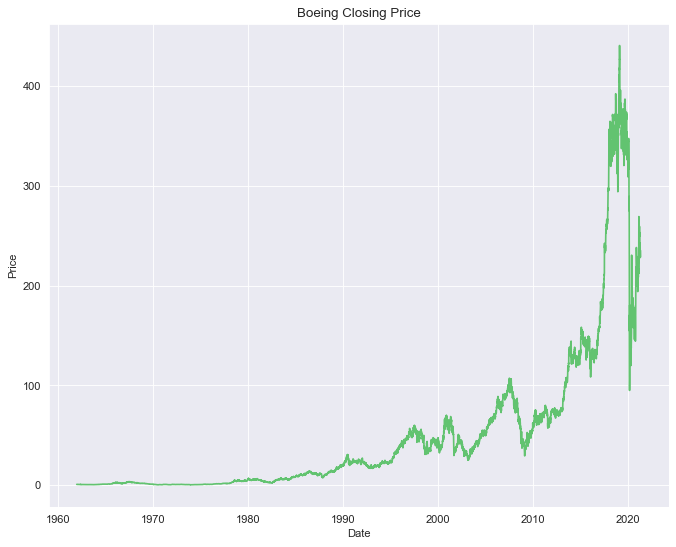

In [64]:
figure(figsize=(10, 8), dpi=80)

sns.set_style("darkgrid")
sns.lineplot(x=boeing_df.index,y=boeing_df.close,data=boeing_df)
sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot

plt.title('Boeing Closing Price')
plt.xlabel('Date')
plt.ylabel('Price');

#### Indexed Boeing dataframe

In [8]:
boeing_df.head()

,date,open,high,low,close,adj_close,volume,year,month,day,week_of_year,day_of_week,day_of_week_number,close_open_variation,intraday_variation,daily_change,moving_average_10,moving_average_15,moving_average_50
date,,,,,,,,,,,,,,,,,,,
1962-01-02,1962-01-02,0.837449,0.837449,0.823045,0.823045,0.190931,352350,1962,1,2,1,Tuesday,2,-1.719985,1.750087,0.000000,0.823045,0.823045,0.823045
1962-01-03,1962-01-03,0.835391,0.851852,0.835391,0.839506,0.194749,710775,1962,1,3,1,Wednesday,3,0.492584,1.970455,0.020000,0.831276,0.831276,0.831276
1962-01-04,1962-01-04,0.839506,0.853909,0.831276,0.831276,0.192840,911250,1962,1,4,1,Thursday,4,-0.980338,2.722682,-0.009803,0.831276,0.831276,0.831276
1962-01-05,1962-01-05,0.831276,0.835391,0.792181,0.814815,0.189022,880875,1962,1,5,1,Friday,5,-1.980209,5.454562,-0.019802,0.827160,0.827160,0.827160
1962-01-08,1962-01-08,0.814815,0.829218,0.804527,0.816872,0.189499,473850,1962,1,8,2,Monday,1,0.252450,3.069008,0.002524,0.825103,0.825103,0.825103


#### Plot the Rolling Mean and Standard Deviation of the Opening price variable to determine if time series is Stationary

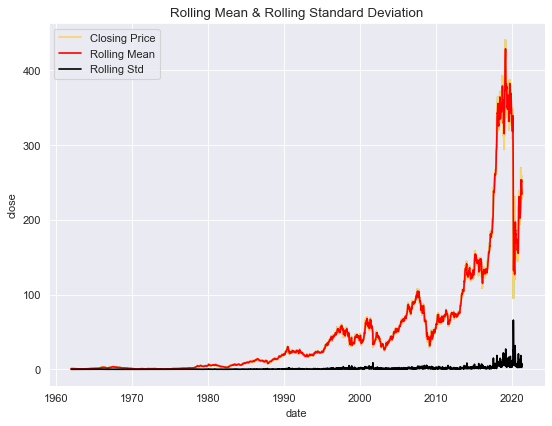

In [9]:
rolling_mean = boeing_df['close'].rolling(window = 12,min_periods = 1).mean()
rolling_std = boeing_df['close'].rolling(window = 12,min_periods = 1).std()

figure(figsize=(8, 6), dpi=80)

# Change default palette
sns.lineplot(x=boeing_df.index,y=boeing_df.close,data=boeing_df)
sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot


plt.title('Rolling Mean & Rolling Standard Deviation of Apple Opening Stock Price')
plt.plot(boeing_df.close, label = "Closing Price")

plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

#### From 'statsmodels' use the Augmented Dickey Fuller Test to determine stationarity 

In [10]:
result = adfuller(boeing_df.close)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.1217522673999756
p-value: 0.706319864230257
Critical Values:
	1%: -3.4307889842949613
	5%: -2.8617340119713086
	10%: -2.566873267906312


# Get Stationarity 

### First Difference

In [11]:
# Drop the first row of 'Close' column because It has 'NaN' value
first_order_diff = boeing_df['close'].diff(1).dropna()

# Display the first five records
first_order_diff.head()

date
1962-01-03    0.016461
1962-01-04   -0.008230
1962-01-05   -0.016461
1962-01-08    0.002057
1962-01-09    0.002058
Name: close, dtype: float64

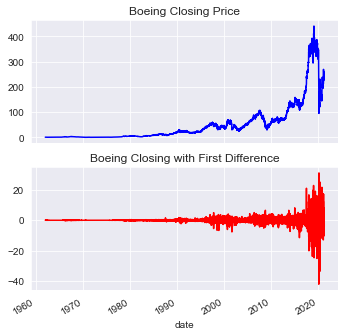

In [12]:
# Declare the fig abd ax as two arguments 
fig, ax = plt.subplots(2, sharex = True)
fig.set_size_inches(5.5, 5.5)
boeing_df['close'].plot(ax = ax[0], color = 'b');
ax[0].set_title('Boeing Closing Price')
first_order_diff.plot(ax = ax[1], color = 'r')
ax[1].set_title('Boeing Closing with First Difference');

In [13]:
result = adfuller(boeing_df.close)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.1217522673999756
p-value: 0.706319864230257
Critical Values:
	1%: -3.4307889842949613
	5%: -2.8617340119713086
	10%: -2.566873267906312


### Function For Autocorrelation and Partial Autocorrelation plots


In [14]:
# plotds is method to plot time series, ACF and PACF
def plotds(xt, nlag = 30, fig_size = (12, 10)):
    if not isinstance(xt, pd.Series):
         xt = pd.Series(xt)
    plt.figure(figsize=fig_size)
    layout = (2, 2)
    
    ax_xt = plt.subplot2grid(layout, (0, 0), colspan = 2)
    ax_acf= plt.subplot2grid(layout, (1, 0))
    ax_pacf = plt.subplot2grid(layout, (1, 1))
    
    xt.plot(ax = ax_xt)
    ax_xt.set_title('Time Series')
    plot_acf(xt, lags = 50, ax = ax_acf)
    plot_pacf(xt, lags = 50, ax = ax_pacf)
    plt.tight_layout()
    return None

### ACF and PACF plot for First Difference method

ADF Statistic: -17.445855
p-value: 0.000000


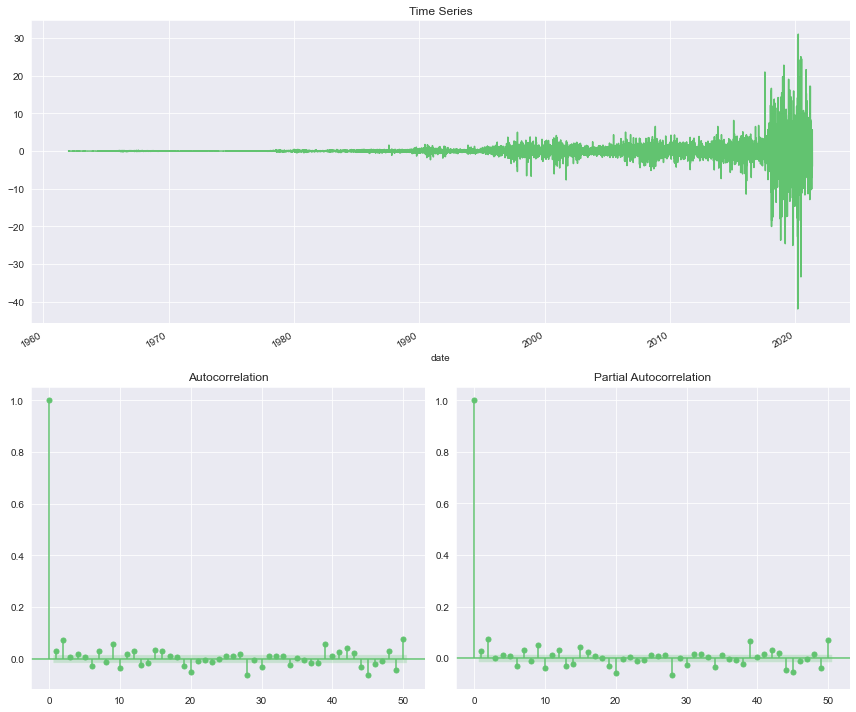

In [15]:
# plot the data with 50 lags
plotds(first_order_diff, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(first_order_diff)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

## Log10 Method

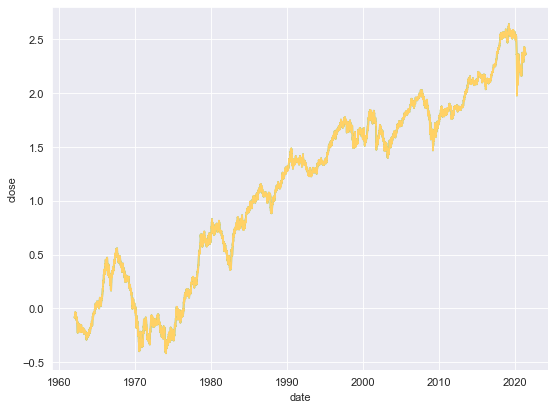

In [16]:
df_close_log = np.log10(boeing_df.close)
figure(figsize=(8, 6), dpi=80)
sns.lineplot(x=df_close_log.index,y=df_close_log)
plt.plot(df_close_log);

### ACF and PACF plot for Logarithm method

ADF Statistic: -0.616785
p-value: 0.867144


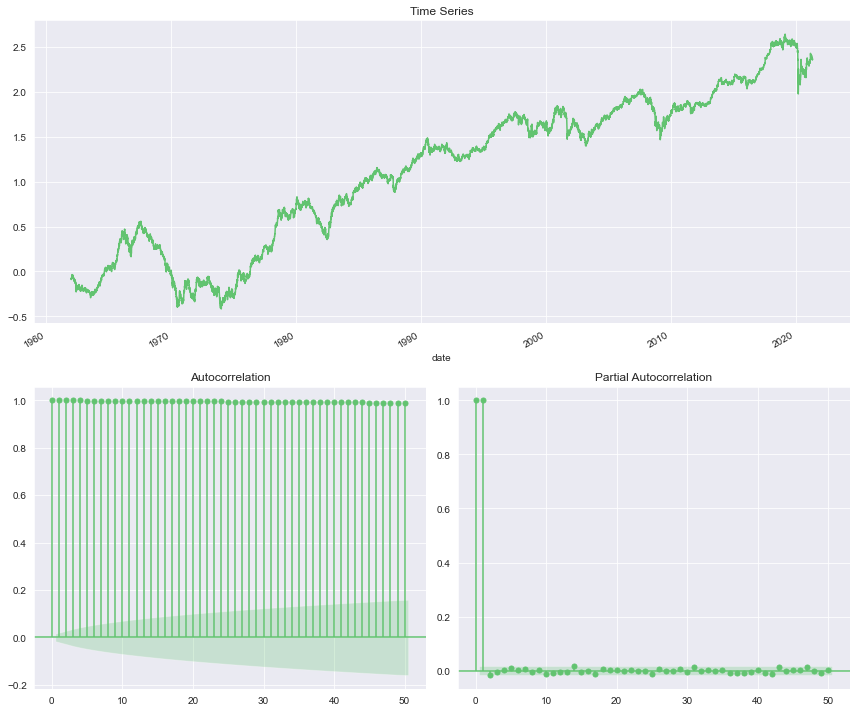

In [17]:
# plot the data with 50 lags
plotds(df_close_log, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(df_close_log)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

### Function for calculating rolling mean and standard deviation 

In [18]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12,min_periods = 1).mean()
    rolling_std = timeseries.rolling(window=12,min_periods = 1).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
 
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))


## Subtract Rolling Mean Method

In [19]:
boeing_df.close.isnull()

date
1962-01-02    False
1962-01-03    False
1962-01-04    False
1962-01-05    False
1962-01-08    False
              ...  
2021-05-05    False
2021-05-06    False
2021-05-07    False
2021-05-10    False
2021-05-11    False
Name: close, Length: 14942, dtype: bool

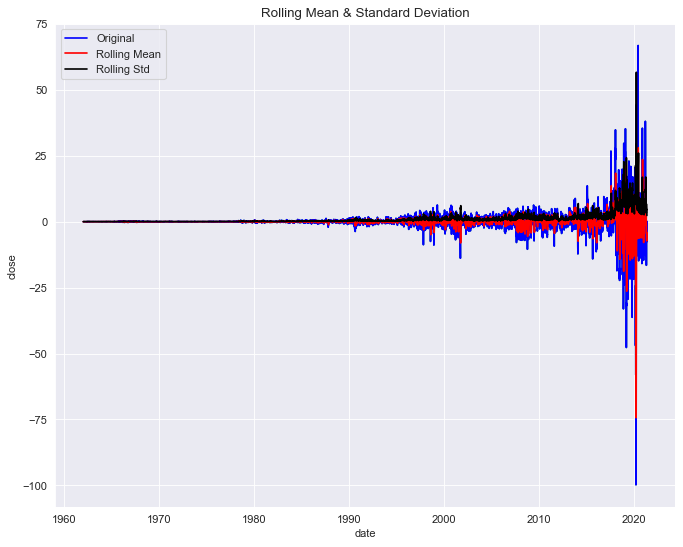

ADF Statistic: -18.802305545399552
p-value: 2.0227989743028784e-30
Critical Values:
	1%: -3.4307889842949613
	5%: -2.8617340119713086
	10%: -2.566873267906312


In [20]:
rolling_mean = boeing_df.close.rolling(window=12,min_periods = 1).mean()
figure(figsize=(10, 8), dpi=80)

df_minus_mean = boeing_df.close - rolling_mean
df_minus_mean.dropna(inplace=True)
sns.lineplot(x=boeing_df.index,y=df_minus_mean)
#sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot

get_stationarity(df_minus_mean);


ADF Statistic: -18.802306
p-value: 0.000000


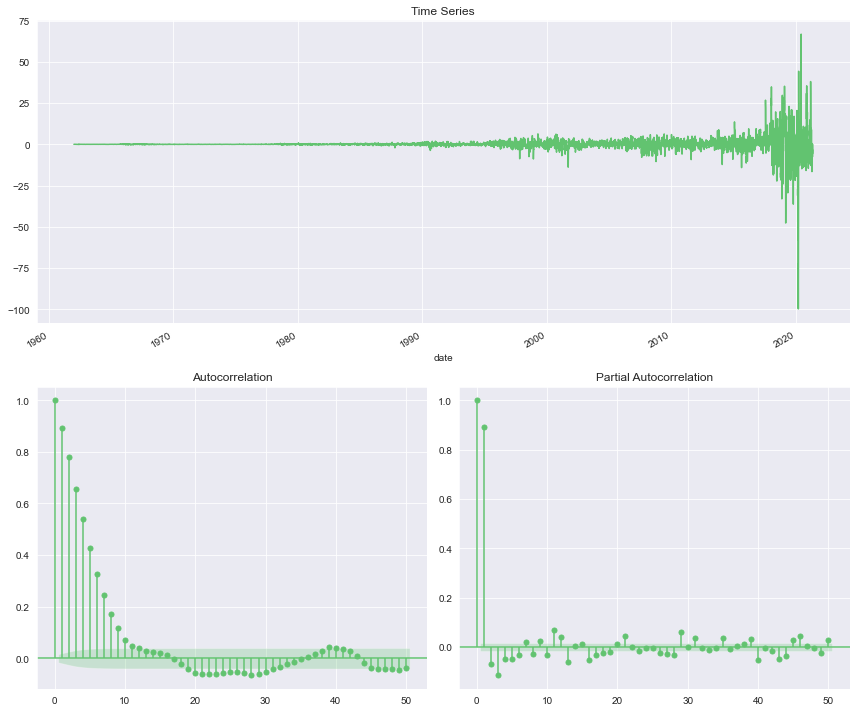

In [21]:
# plot the data with 50 lags
plotds(df_minus_mean, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(df_minus_mean)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

## Exponential Decay Method

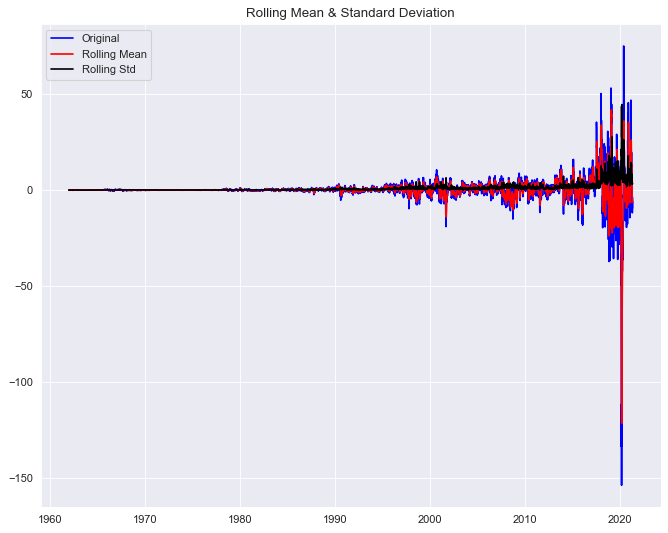

ADF Statistic: -15.84054657379205
p-value: 9.704096285746424e-29
Critical Values:
	1%: -3.4307889842949613
	5%: -2.8617340119713086
	10%: -2.566873267906312


In [22]:
rolling_mean_exp_decay = boeing_df.close.ewm(halflife=12, min_periods=0, adjust=True).mean()
figure(figsize=(10, 8), dpi=80)
df_exp_decay = boeing_df.close - rolling_mean_exp_decay
df_exp_decay.dropna(inplace=True)
exp_stationary = get_stationarity(df_exp_decay)

### ACF and PACF plot for Exponential Decay method

ADF Statistic: -15.840547
p-value: 0.000000


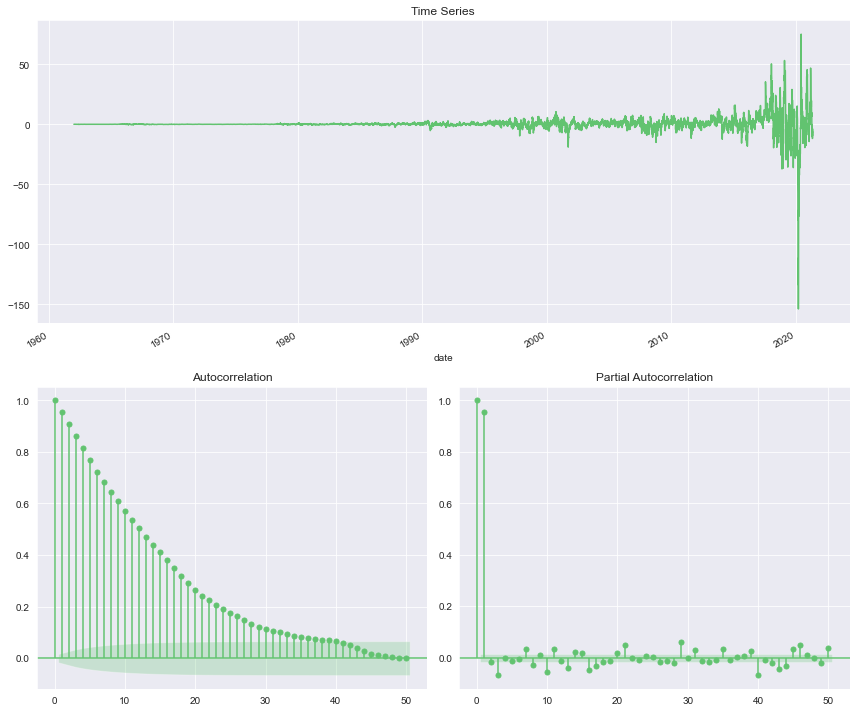

In [23]:
# plot the data with 50 lags
plotds(df_exp_decay, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(df_exp_decay)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

## Time Shift Method

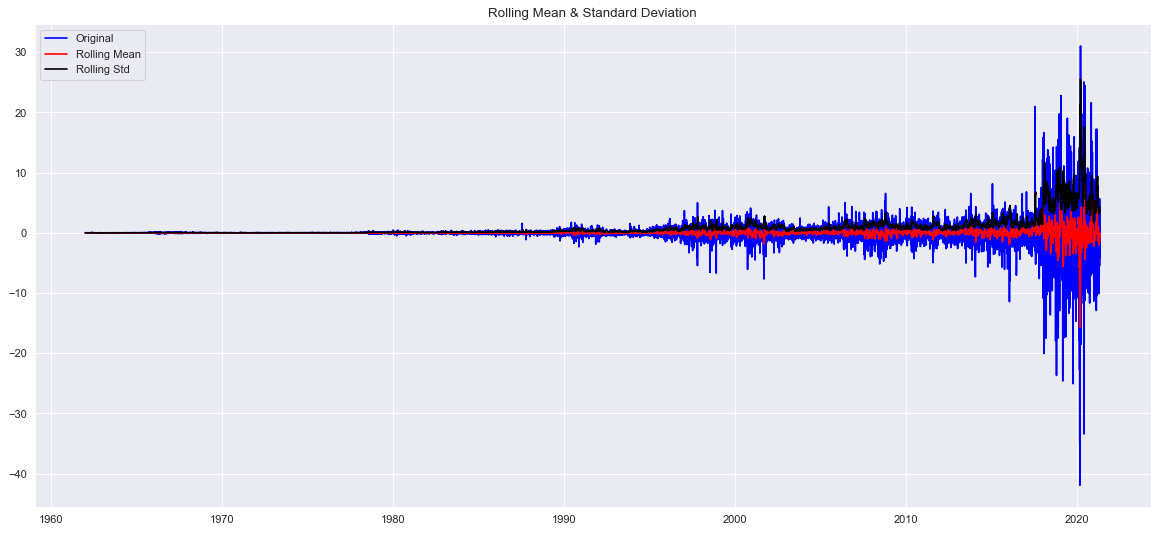

ADF Statistic: -17.445854550288754
p-value: 4.6818155565231855e-30
Critical Values:
	1%: -3.430789013766029
	5%: -2.8617340249952763
	10%: -2.566873274838824


In [24]:
figure(figsize=(18, 8), dpi=80)

df_shift = boeing_df.close - boeing_df.close.shift()
df_shift.dropna(inplace=True)
get_stationarity(df_shift)

### ACF and PACF plot for Time Shift method

ADF Statistic: -17.445855
p-value: 0.000000


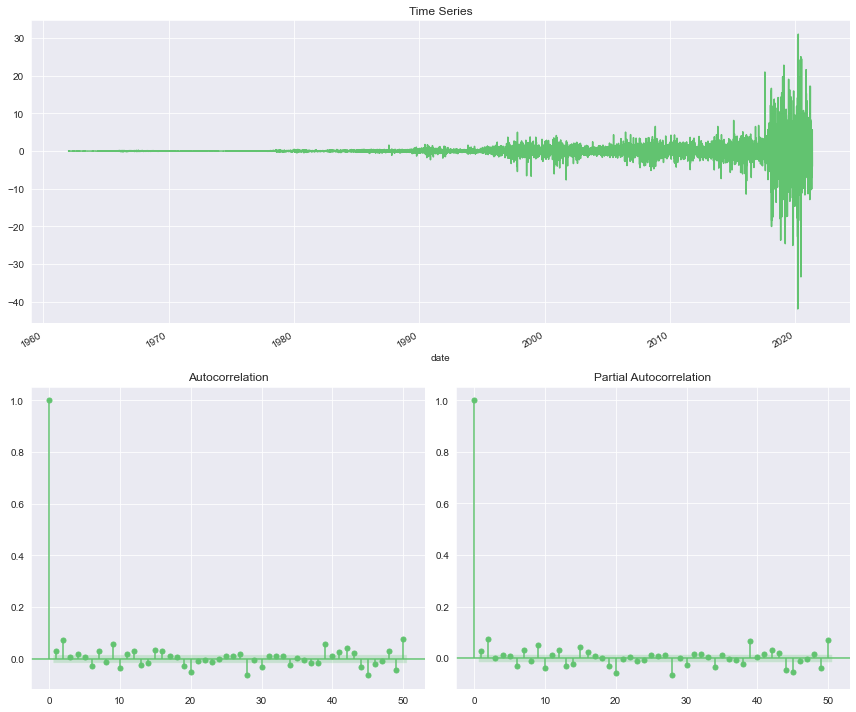

In [25]:
# plot the data with 50 lags
plotds(df_shift, nlag = 50)

# Perform Dicky Fuller test
adf_result = adfuller(df_shift)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

### Import Train Test Split

In [26]:
%store -r XB1_train
%store -r XB1_test

%store -r XB7_train
%store -r XB7_test

%store -r XB30_train
%store -r XB30_test

%store -r XB90_train
%store -r XB90_test


### Set Indicies

In [27]:
XB1_train.set_index(['date'], inplace = True)
XB7_train.set_index(['date'], inplace = True)
XB30_train.set_index(['date'], inplace = True)
XB90_train.set_index(['date'], inplace = True)


### Determine Differencing parameters to Stationarize

In [28]:
model_autoARIMA = auto_arima(XB1_train.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=72568.948, Time=0.44 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=67784.942, Time=1.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=8.35 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=72566.948, Time=0.29 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=66417.883, Time=0.96 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=65556.407, Time=1.58 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=21.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=24.07 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=65554.407, Time=1.17 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=66415.883, Time=0.65 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=10.89 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=6.75 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 77.364 seconds
                               SARIMAX Results                                
Dep. Variable:         

In [29]:
model_autoARIMA = auto_arima(XB7_train.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=72541.913, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=67750.077, Time=1.12 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.57 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=72539.913, Time=0.33 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=66384.499, Time=1.08 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=65524.221, Time=1.94 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=23.21 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=18.93 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=65522.221, Time=1.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=66382.499, Time=0.65 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=8.64 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=4.81 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 71.824 seconds
                               SARIMAX Results                                
Dep. Variable:          

In [30]:
model_autoARIMA = auto_arima(XB30_train.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=72423.271, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=67634.960, Time=1.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=14.09 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=72421.272, Time=0.34 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=66264.219, Time=1.09 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=65403.498, Time=2.03 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=30.09 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=18.74 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=65401.498, Time=1.09 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=66262.219, Time=0.54 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=7.30 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=3.69 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 80.537 seconds
                               SARIMAX Results                                
Dep. Variable:         

In [31]:
model_autoARIMA = auto_arima(XB90_train.close, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=2,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=2, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=71641.491, Time=0.42 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=66866.190, Time=1.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.29 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=71639.491, Time=0.34 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=65607.494, Time=1.11 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=64662.144, Time=1.29 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=22.44 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=23.23 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=64660.144, Time=0.86 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=65605.494, Time=0.65 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=inf, Time=10.43 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=inf, Time=7.78 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 78.952 seconds
                               SARIMAX Results                                
Dep. Variable:         

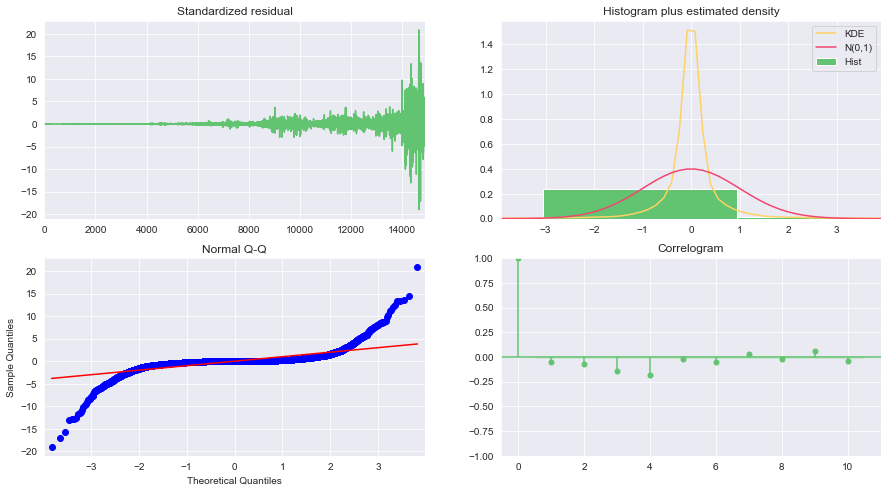

In [32]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

# Fit Models

### Fit 1 Day Model

In [33]:
XB1_train

,open,high,low,close,adj_close,volume,year,month,day,week_of_year,day_of_week,day_of_week_number,close_open_variation,intraday_variation,daily_change,moving_average_10,moving_average_15,moving_average_50
date,,,,,,,,,,,,,,,,,,
1962-01-02,0.837449,0.837449,0.823045,0.823045,0.190931,352350,1962,1,2,1,Tuesday,2,-1.719985,1.750087,0.000000,0.823045,0.823045,0.823045
1962-01-03,0.835391,0.851852,0.835391,0.839506,0.194749,710775,1962,1,3,1,Wednesday,3,0.492584,1.970455,0.020000,0.831276,0.831276,0.831276
1962-01-04,0.839506,0.853909,0.831276,0.831276,0.192840,911250,1962,1,4,1,Thursday,4,-0.980338,2.722682,-0.009803,0.831276,0.831276,0.831276
1962-01-05,0.831276,0.835391,0.792181,0.814815,0.189022,880875,1962,1,5,1,Friday,5,-1.980209,5.454562,-0.019802,0.827160,0.827160,0.827160
1962-01-08,0.814815,0.829218,0.804527,0.816872,0.189499,473850,1962,1,8,2,Monday,1,0.252450,3.069008,0.002524,0.825103,0.825103,0.825103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,234.110001,237.100006,233.809998,235.190002,235.190002,9887800,2021,5,3,18,Monday,1,0.461322,1.407129,0.003756,236.750002,241.109333,241.977400
2021-05-04,235.750000,236.649994,225.649994,233.630005,233.630005,17807200,2021,5,4,18,Tuesday,2,-0.899256,4.874806,-0.006633,236.707002,239.800000,242.392400
2021-05-05,232.449997,232.449997,227.559998,228.179993,228.179993,8538800,2021,5,5,18,Wednesday,3,-1.836956,2.148883,-0.023328,235.933002,238.183333,242.713600


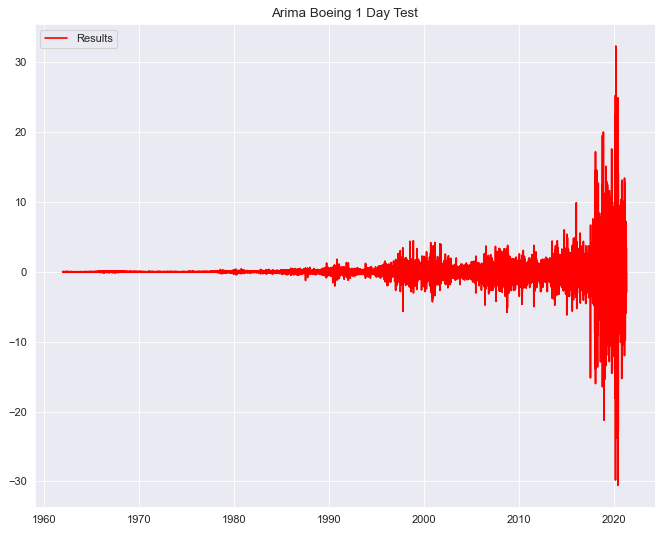

In [35]:
model1 = ARIMA(XB1_train.close, order=(3,2,0)); # Best p,d,q parameters from auto_arima
results1 = model1.fit();
figure(figsize=(10, 8), dpi=80);
plt.plot(results1.fittedvalues, color='red',label='Results');
plt.title('Arima Boeing 1 Day Test')
plt.legend()

In [42]:
# Perform Dicky Fuller test
adf_result = adfuller(results1.fittedvalues)

# Display the outcomes
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

ADF Statistic: -30.526303
p-value: 0.000000


### Fit 7 Day Model

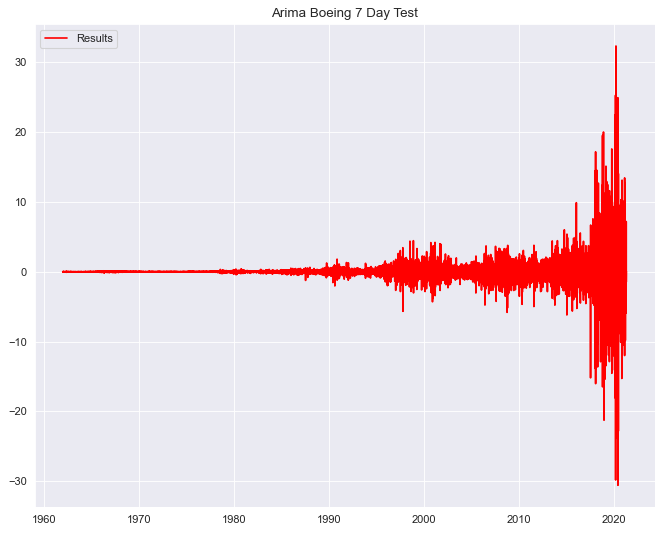

In [38]:
model7 = ARIMA(XB7_train.close, order=(3,2,0)); # Best p,d,q parameters from auto_arima
results7 = model7.fit();
figure(figsize=(10, 8), dpi=80);
plt.plot(results7.fittedvalues, color='red',label='Results');
plt.title('Arima Boeing 7 Day Test')
plt.legend()

### Fit 30 Day Model

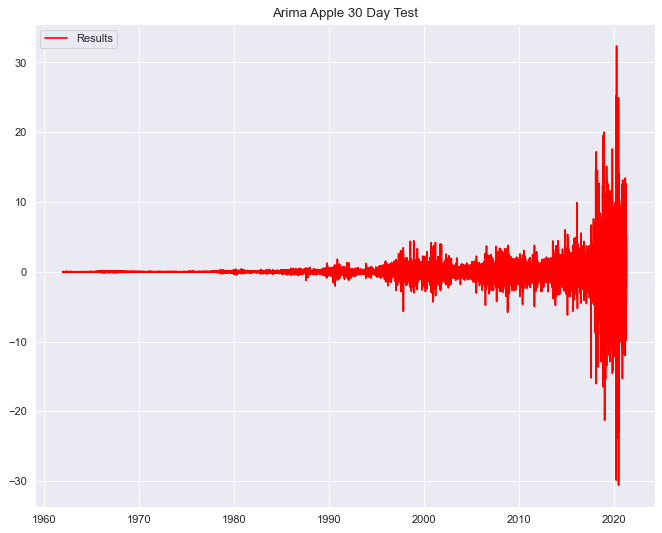

In [43]:
model30 = ARIMA(XB30_train.close, order=(3,2,0)); # Best p,d,q parameters from auto_arima
results30 = model30.fit();
figure(figsize=(10, 8), dpi=80);
plt.plot(results30.fittedvalues, color='red',label='Results');
plt.title('Arima Boeing 30 Day Test')
plt.legend()

### Fit 90 Day Model

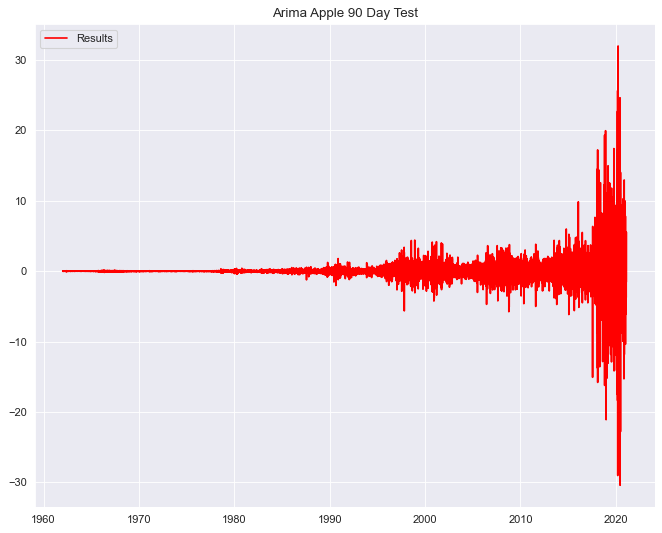

In [44]:
model90 = ARIMA(XB90_train.close, order=(3,2,0)); # Best p,d,q parameters from auto_arima
results90 = model90.fit();
figure(figsize=(10, 8), dpi=80);
plt.plot(results90.fittedvalues, color='red',label='Results');
plt.title('Arima Boeing 90 Day Test')
plt.legend()

### Plot Predicted values and Original values based on 1 Day Test data

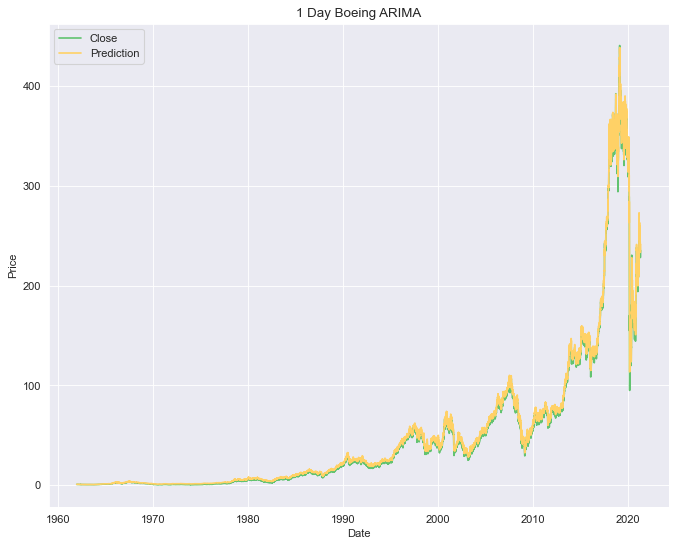

In [46]:
predictions_ARIMA_diff1 = pd.Series(results1.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum1 = predictions_ARIMA_diff1.cumsum()
predictions_ARIMA1 = pd.Series(XB1_train['close'], index=XB1_train.index)
predictions_ARIMA1 = predictions_ARIMA1.add(predictions_ARIMA_diff_cumsum1, fill_value=0)
figure(figsize=(10, 8), dpi=80);
plt.plot(XB1_train['close'], label='Close') 
plt.plot(predictions_ARIMA1,label='Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('1 Day Boeing ARIMA')
plt.legend() 

### 7 Day Train Prediction

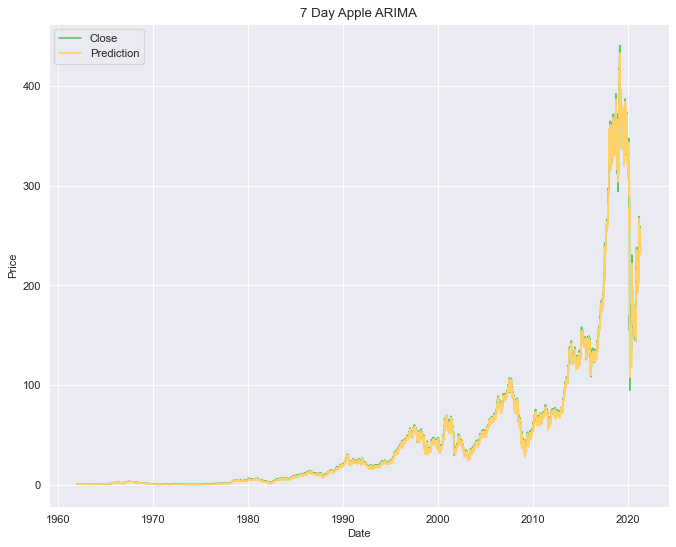

In [47]:
predictions_ARIMA_diff7 = pd.Series(results7.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum7 = predictions_ARIMA_diff7.cumsum()
predictions_ARIMA7 = pd.Series(XB7_train['close'], index=XB7_train.index)
predictions_ARIMA7 = predictions_ARIMA7.add(predictions_ARIMA_diff_cumsum7, fill_value=0)

figure(figsize=(10, 8), dpi=80);
plt.plot(XB7_train['close'], label='Close') 
plt.plot(predictions_ARIMA7,label='Prediction')
plt.title('7 Day Boeing ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

### 30 Day Train Prediction

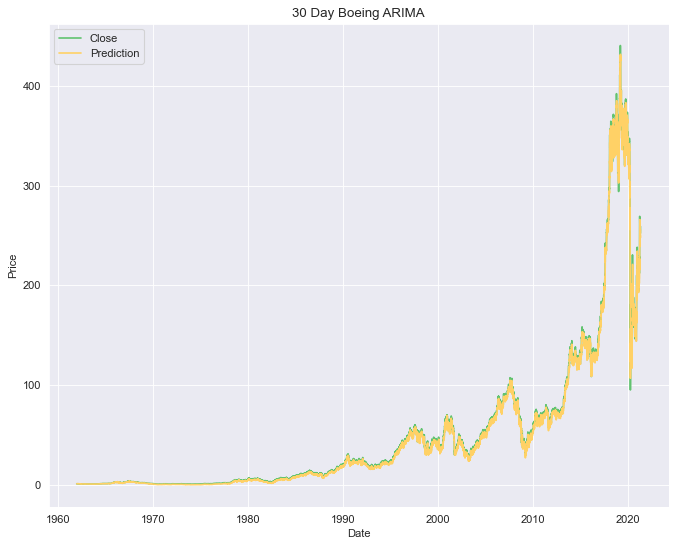

In [48]:
predictions_ARIMA_diff30 = pd.Series(results30.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum30 = predictions_ARIMA_diff30.cumsum()
predictions_ARIMA30 = pd.Series(XB30_train['close'], index=XB30_train.index)
predictions_ARIMA30 = predictions_ARIMA30.add(predictions_ARIMA_diff_cumsum30, fill_value=0)

figure(figsize=(10, 8), dpi=80);
plt.plot(XB30_train['close'], label='Close') 
plt.plot(predictions_ARIMA30,label='Prediction')
plt.title('30 Day Boeing ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()    

### 90 Day Train Prediction

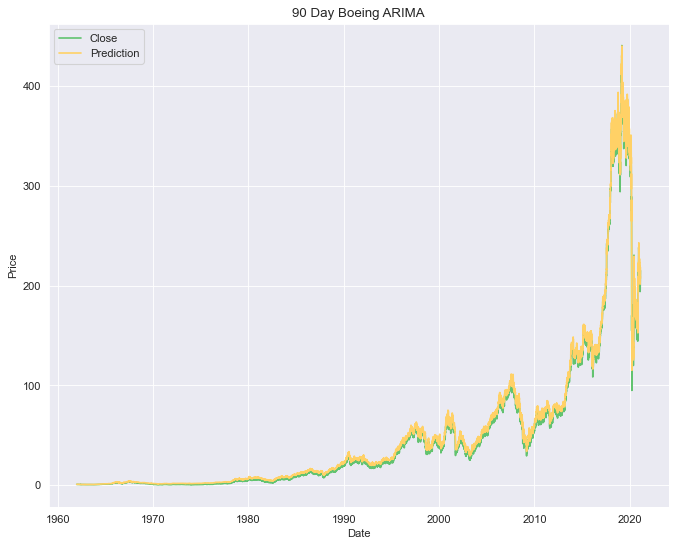

In [49]:
predictions_ARIMA_diff90 = pd.Series(results90.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum90 = predictions_ARIMA_diff90.cumsum()
predictions_ARIMA90 = pd.Series(XB90_train['close'], index=XB90_train.index)
predictions_ARIMA90 = predictions_ARIMA90.add(predictions_ARIMA_diff_cumsum90, fill_value=0)

figure(figsize=(10, 8), dpi=80);
plt.plot(XB90_train['close'], label='Close') 
plt.plot(predictions_ARIMA90,label='Prediction')
plt.title('90 Day Boeing ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()    

### 1 Day Forecast

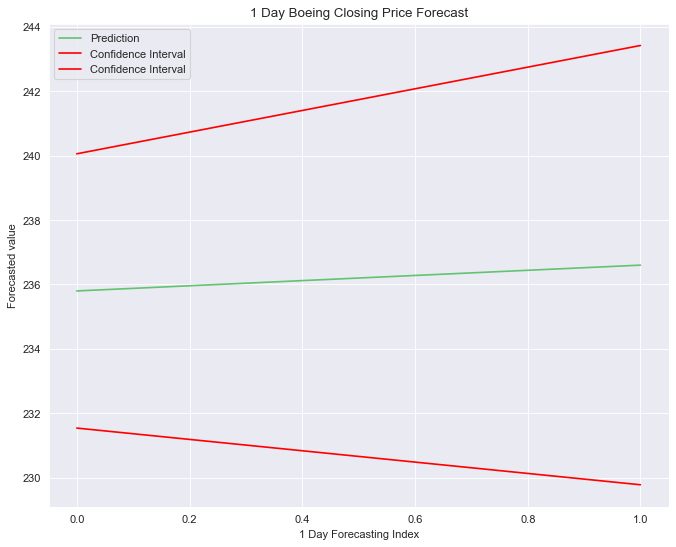

In [50]:
f, err, ci = results1.forecast(2)
figure(figsize=(10, 8), dpi=80);
plt.plot(f,label = 'Prediction');
plt.plot(ci,label='Confidence Interval',color='r');
plt.xlabel('1 Day Forecasting Index');
plt.ylabel('Forecasted value');
plt.title('1 Day Boeing Closing Price Forecast');
plt.legend()

# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure


14940    232.929993
14941    228.880005
Name: close, dtype: float64


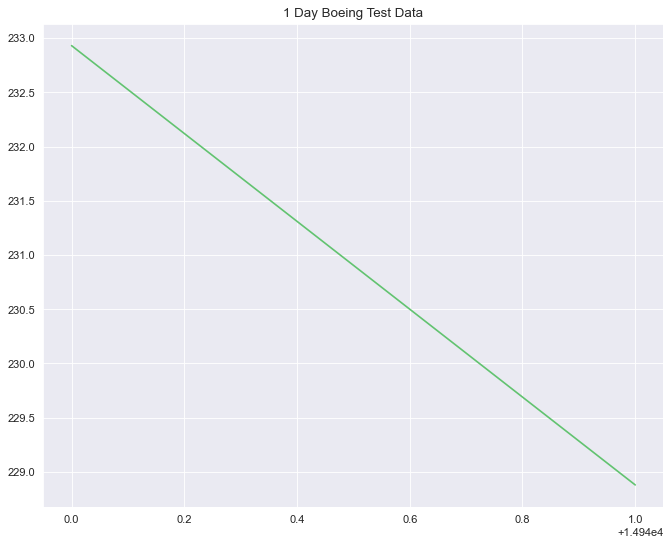

In [52]:
figure(figsize=(10, 8), dpi=80);
plt.plot(XB1_test.close)
plt
plt.title('1 Day Boeing Test Data');
print(XB1_test.close)

### 7 Day Forecast

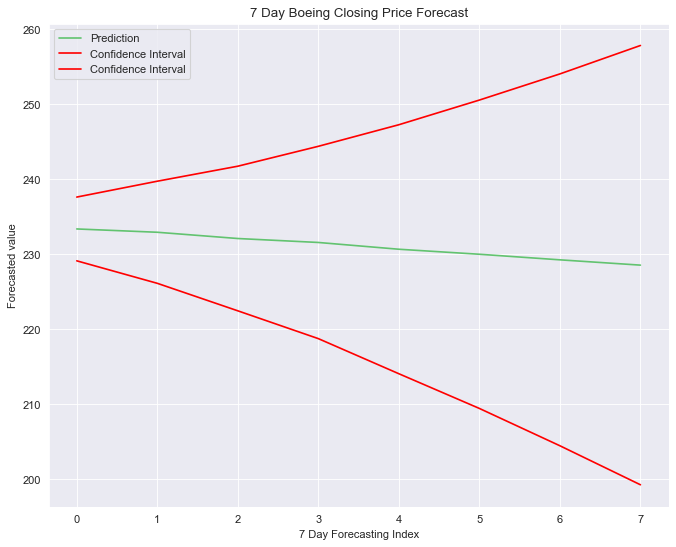

In [53]:
f, err, ci = results7.forecast(8)
figure(figsize=(10, 8), dpi=80);
plt.plot(f,label = 'Prediction');
plt.plot(ci,label='Confidence Interval',color='r');
plt.xlabel('7 Day Forecasting Index');
plt.ylabel('Forecasted value');
plt.title('7 Day Boeing Closing Price Forecast');
plt.legend()

# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure


14920    249.520004
14921    253.270004
14922    252.429993
14923    251.110001
14924    248.179993
14925    244.149994
14926    234.059998
14927    235.919998
14928    234.330002
14929    238.380005
14930    241.440002
14931    242.470001
14932    235.460007
14933    235.940002
14934    234.309998
14935    235.190002
14936    233.630005
14937    228.179993
14938    229.809998
14939    235.470001
14940    232.929993
14941    228.880005
Name: close, dtype: float64


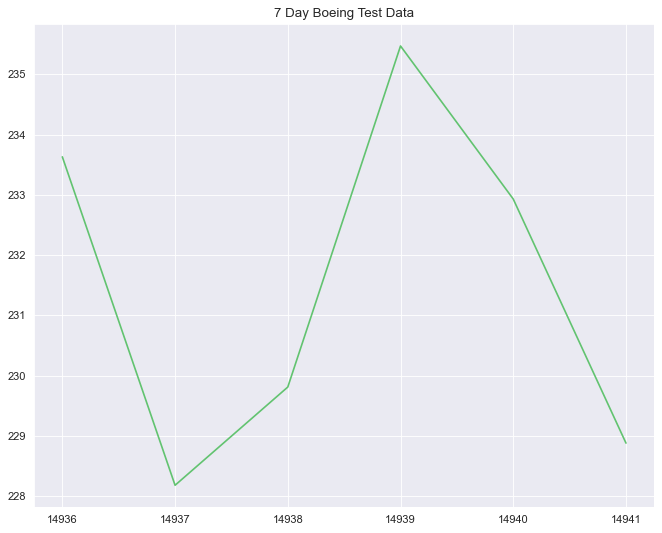

In [54]:
figure(figsize=(10, 8), dpi=80);
plt.plot(XB7_test.close)
plt
plt.title('7 Day Boeing Test Data');
print(XB30_test.close)

### 30 Day Forecast

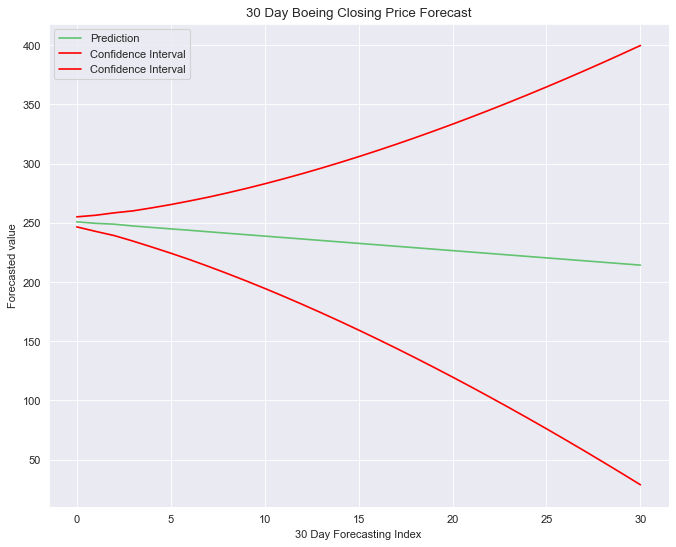

In [55]:
f, err, ci = results30.forecast(31)
figure(figsize=(10, 8), dpi=80);
plt.plot(f,label = 'Prediction');
plt.plot(ci,label='Confidence Interval',color='r');
plt.xlabel('30 Day Forecasting Index');
plt.ylabel('Forecasted value');
plt.title('30 Day Boeing Closing Price Forecast');
plt.legend()

# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure


14920    249.520004
14921    253.270004
14922    252.429993
14923    251.110001
14924    248.179993
14925    244.149994
14926    234.059998
14927    235.919998
14928    234.330002
14929    238.380005
14930    241.440002
14931    242.470001
14932    235.460007
14933    235.940002
14934    234.309998
14935    235.190002
14936    233.630005
14937    228.179993
14938    229.809998
14939    235.470001
14940    232.929993
14941    228.880005
Name: close, dtype: float64


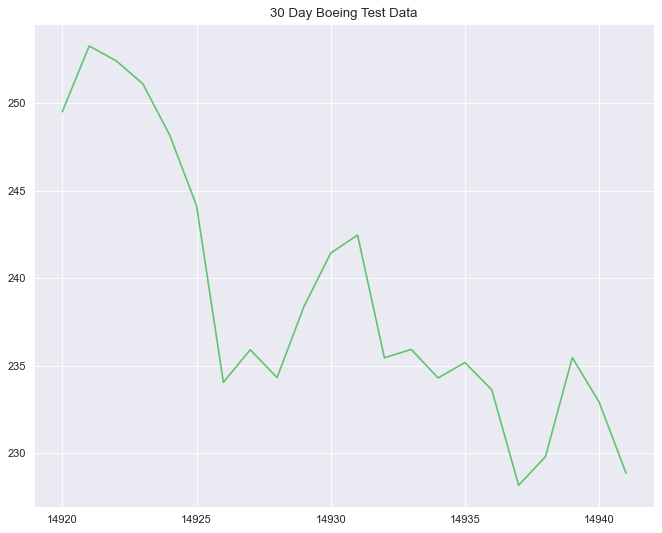

In [57]:
figure(figsize=(10, 8), dpi=80);
plt.plot(XB30_test.close)
plt
plt.title('30 Day Boeing Test Data');
print(XB30_test.close)

### 90 Day Forecast

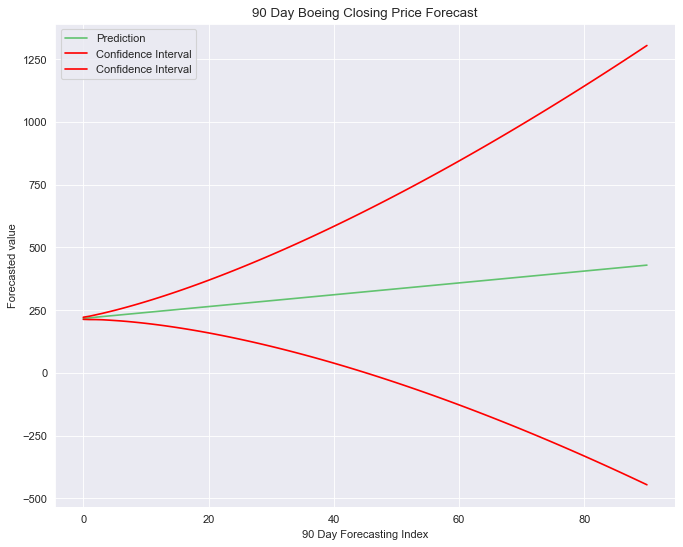

In [58]:
f, err, ci = results90.forecast(91)
figure(figsize=(10, 8), dpi=80);
plt.plot(f,label = 'Prediction');
plt.plot(ci,label='Confidence Interval',color='r');
plt.xlabel('90 Day Forecasting Index');
plt.ylabel('Forecasted value');
plt.title('90 Day Boeing Closing Price Forecast');
plt.legend()

# The forecasting estimates and confidence interval obtained using the preceding script is shown in Figure


14879    211.919998
14880    210.660004
14881    210.979996
14882    217.179993
14883    215.520004
            ...    
14937    228.179993
14938    229.809998
14939    235.470001
14940    232.929993
14941    228.880005
Name: close, Length: 63, dtype: float64


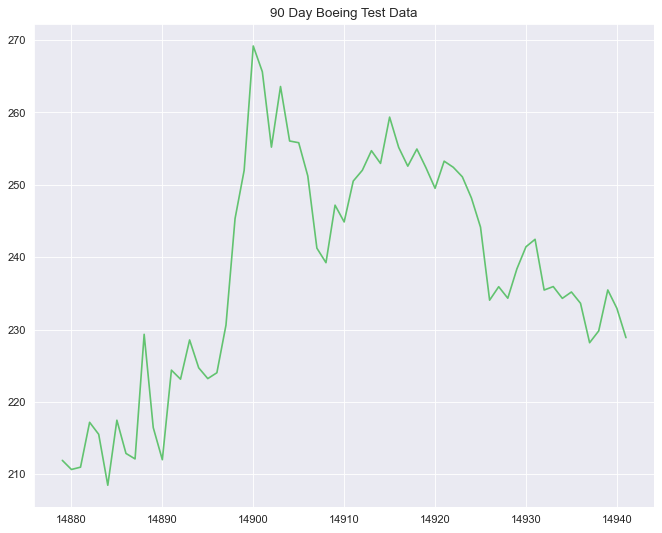

In [59]:
figure(figsize=(10, 8), dpi=80);
plt.plot(XB90_test.close)
plt
plt.title('90 Day Boeing Test Data')
print(XB90_test.close)

## Evaluation

### Calculations to determine accuracy of the ARIMA model predictions

In [68]:
mse = mean_squared_error(XB1_train.close, predictions_ARIMA1)
print('1 day test data MSE: '+str(mse))

mae = mean_absolute_error (XB1_train.close,predictions_ARIMA1)
print('1 day test data MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(XB1_train.close,predictions_ARIMA1))
print('1 day test data RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_ARIMA1 -  XB1_train.close)/np.abs(XB1_train.close))
print('1 day test data MAPE: '+str(mape))


1 day test data MSE: 8.698834485225882
1 day test data MAE: 2.1193105696364896
1 day test data RMSE: 2.949378660875182
1 day test data MAPE: 0.24884539509764086


In [71]:
mse = mean_squared_error(XB7_train.close, predictions_ARIMA7)
print('7 day test data MSE: '+str(mse))
mae = mean_absolute_error (XB7_train.close,predictions_ARIMA7)
print('7 day test data MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(XB7_train.close,predictions_ARIMA7))
print('7 day test data RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_ARIMA7 -  XB7_train.close)/np.abs(XB7_train.close))
print('7 day test data MAPE: '+str(mape))


7 day test data MSE: 4.504706652578561
7 day test data MAE: 1.1528904578024557
7 day test data RMSE: 2.1224294222844162
7 day test data MAPE: 0.10582577400163976


In [72]:
mse = mean_squared_error(XB30_train.close, predictions_ARIMA30)
print('30 day test data MSE: '+str(mse))

mae = mean_absolute_error (XB30_train.close,predictions_ARIMA30)
print('30 day test data MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(XB30_train.close,predictions_ARIMA30))
print('30 day test data RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_ARIMA30 -  XB30_train.close)/np.abs(XB30_train.close))
print('30 day test data MAPE: '+str(mape))


30 day test data MSE: 6.46538689807466
30 day test data MAE: 1.6812653474150918
30 day test data RMSE: 2.542712507947892
30 day test data MAPE: 0.17874480380137325


In [73]:
mse = mean_squared_error(XB90_train.close, predictions_ARIMA90)
print('90 day test data MSE: '+str(mse))

mae = mean_absolute_error (XB90_train.close,predictions_ARIMA90)
print('90 day test data MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(XB90_train.close,predictions_ARIMA90))
print('90 day test data RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions_ARIMA90 -  XB90_train.close)/np.abs(XB90_train.close))
print('90 day test data MAPE: '+str(mape))


90 day test data MSE: 14.170218910008668
90 day test data MAE: 2.936701425329002
90 day test data RMSE: 3.764335121905151
90 day test data MAPE: 0.35598331476765865
